In [5]:
import torch

In [6]:
torch.cuda.empty_cache() 

In [7]:
import pandas as pd
import numpy as np
import sys
sys.path.append("../src/utils")
from utils import SimpleGraphVoltDatasetLoader, read_and_prepare_data

In [8]:
trafo_id = "T1330"
loader = SimpleGraphVoltDatasetLoader(trafo_id)

In [9]:
loader_data = loader.get_dataset(num_timesteps_in=12, num_timesteps_out=4)

(2, 114)
(114, 5)
(114,)
(70065, 113, 21, 12)
(70065, 113, 4)


In [7]:
from torch_geometric_temporal.signal import temporal_signal_split

In [8]:
train_dataset, test_dataset = temporal_signal_split(loader_data, train_ratio=0.2)

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        out_channels = 32
        self.tgnn = A3TGCN(in_channels=node_features, 
                           out_channels=out_channels, 
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(out_channels, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        h = F.relu(h)
        h = self.linear(h)
        return h

TemporalGNN(node_features=16, periods=4)

TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(16, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(16, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(16, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=4, bias=True)
)

In [10]:
# GPU support
device = torch.device('cuda') # cuda
subset = 2000

# Create model and optimizers
model = TemporalGNN(node_features=21, periods=4).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

epochs_loss = []

print("Running training...")
for epoch in range(200): 
    loss = 0
    step = 0
    print(f"--------- Epoch {epoch} ---------")
    for snapshot in train_dataset:
        #print(f"--- Step {step} ---")
        snapshot = snapshot.to(device)
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index)
        # Mean squared error
        intermedaiate_loss = torch.mean((y_hat-snapshot.y)**2) 
        loss = loss + intermedaiate_loss
        step += 1
        if step%1000==0:
          print(f"Intermediate loss at step {step}: {intermedaiate_loss.item()}")
        if step > subset:
          break

    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MSE: {:.4f}".format(epoch, loss.item()))
    epochs_loss.append(loss.detach().cpu().numpy())

Running training...
--------- Epoch 0 ---------
Intermediate loss at step 1000: 1.0082645416259766
Intermediate loss at step 2000: 1.0011528730392456
Epoch 0 train MSE: 1.0073
--------- Epoch 1 ---------
Intermediate loss at step 1000: 0.9779001474380493
Intermediate loss at step 2000: 0.9797667860984802
Epoch 1 train MSE: 0.9812
--------- Epoch 2 ---------
Intermediate loss at step 1000: 0.9573493003845215
Intermediate loss at step 2000: 0.9568012952804565
Epoch 2 train MSE: 0.9575
--------- Epoch 3 ---------
Intermediate loss at step 1000: 0.9268902540206909
Intermediate loss at step 2000: 0.9280620813369751
Epoch 3 train MSE: 0.9265
--------- Epoch 4 ---------
Intermediate loss at step 1000: 0.8844661712646484
Intermediate loss at step 2000: 0.8903769254684448
Epoch 4 train MSE: 0.8881
--------- Epoch 5 ---------
Intermediate loss at step 1000: 0.8365859985351562
Intermediate loss at step 2000: 0.8422982692718506
Epoch 5 train MSE: 0.8416
--------- Epoch 6 ---------
Intermediate los

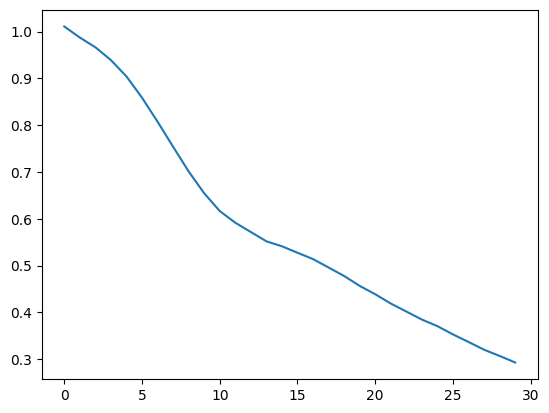

In [13]:
#move rpochs_loss to cpu
epochs_loss = [x.detach().numpy()  for x in epochs_loss]
#plot epochs_loss
import matplotlib.pyplot as plt
plt.plot(epochs_loss)

In [ ]:
loader.mean_and_std["measurements"]["voltage"]

In [11]:
import numpy as np

In [12]:
mses = [1.0111,
0.9851,
0.9684,
0.9485,
0.9200,
0.8830,
0.8386,
0.7912,
0.7413,
0.6904,
0.6466,
0.6131,
0.5871,
0.5717,
0.5581,
0.5464,
0.5343,
0.5181,
0.5022,
0.4869,
0.4703,
0.4532,
0.4352,
0.4160,
0.3949,
0.3722,
0.3511,
0.3352,
0.3214,
0.3076,
0.2932,
0.2793,
0.2666,
0.2552,
0.2447,
0.2350,
0.2280,
0.2227,
0.2163,
0.2086,
0.2023,
0.1965,
0.1884,
0.1794,
0.1694,
0.1565,
0.1455,
0.1377,
0.1315,
0.1268,
0.1226,
0.1175,
0.1121,
0.1068,
0.1018,
0.0972,
0.0935,
0.0909,
0.0888,
0.0863,
0.0830,
0.0788,
0.0758,
0.0744,
0.0735,
0.0719,
0.0696,
0.0674,
0.0659,
0.0652,
0.0648,
0.0640,
0.0628,
0.0611,
0.0596,
0.0587,
0.0583,
0.0580,
0.0577,
0.0570,
0.0560,
0.0550,
0.0541,
0.0536,
0.0533,
0.0534,
0.0537,
0.0535,
0.0527,
0.0509,
0.0498,
0.0499,
0.0503,
0.0502,
0.0492,
0.0481,
0.0474,
0.0474,
0.0475,
0.0473,
0.0467,
0.0460,
0.0455,
0.0452,
0.0451,
0.0451,
0.0452,
0.0455,
0.0459,
0.0462,
0.0458,
0.0445,
0.0432,
0.0429,
0.0434,
0.0438,
0.0432,
0.0422,
0.0417,
0.0420,
0.0422,
0.0418,
0.0410,
0.0407,
0.0408,
0.0409,
0.0406,
0.0401,
0.0397,
0.0396,
0.0396,
0.0395,
0.0394,
0.0390,
0.0387,
0.0384,
0.0381,
0.0379,
0.0377,
0.0375,
0.0374,
0.0374,
0.0377,
0.0389,
0.0419,
0.0473,
0.0480,
0.0399,
0.0367,
0.0424,
0.0389,
0.0361,
0.0401,
0.0365,
0.0363,
0.0383,
0.0349,
0.0362,
0.0362,
0.0341,
0.0357,
0.0344,
0.0337,
0.0348,
0.0334,
0.0333,
0.0338,
0.0326,
0.0327,
0.0330,
0.0320,
0.0319,
0.0322,
0.0315,
0.0311,
0.0314,
0.0309,
0.0305,
0.0305,
0.0304,
0.0299,
0.0297,
0.0297,
0.0295,
0.0291,
0.0289,
0.0288,
0.0286,
0.0283,
0.0280,
0.0278,
0.0277,
0.0274,
0.0271,
0.0268,
0.0266,
0.0264,
0.0262,
0.0260,
0.0258]

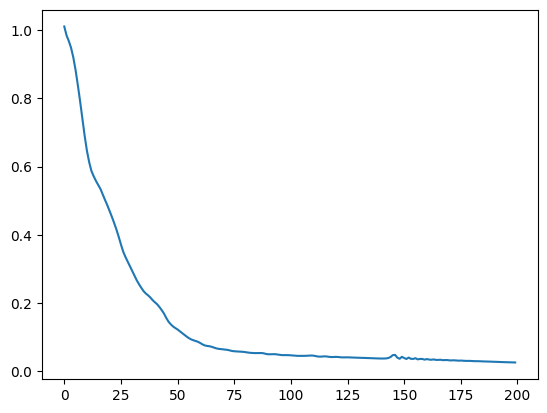

In [3]:
import matplotlib.pyplot as plt
plt.plot(mses)

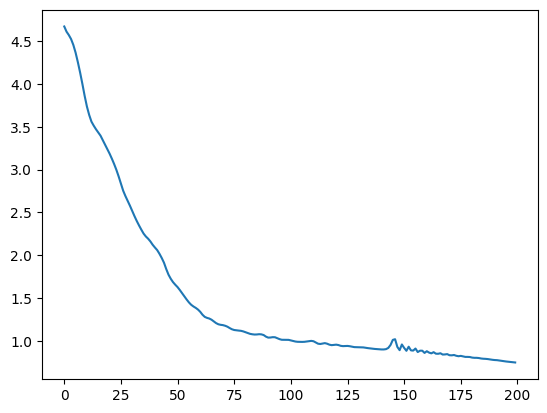

: 

In [15]:
mese_array = np.sqrt(np.array(mses))*4.646129
plt.plot(mese_array)